In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.io import fits
import skimage.io as io 
import struct
import imageio as iio
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2
from PIL import Image
import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
path0 = '/Volumes/WD1T/share/TSE2023/'    # input dir
path1 = '/Volumes/WD1T/share/TSE2023/iPhone/result/'    # input dir
dirrb0 = path0 + 'iPhone/result/'  # results
pathfd  = path0 + 'iPhone/result/m2pic/'  # results
dirr1t = path1 + 'r1dfdatat/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr1t):
    os.makedirs(dirr1t)
    
dirr2t = path1 + 'r2dfdatat/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr2t):
    os.makedirs(dirr2t)
    
dirr2t_png = path1 + 'r2dfdatat_png/'  # r1dfdatat: registration 1st dark flat data totally
if not os.path.exists(dirr2t_png):
    os.makedirs(dirr2t_png)

In [3]:

# delete ._* files
files_to_delete = glob.glob(os.path.join(dirr2t, '._*'))

for file in files_to_delete:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

In [4]:
# 5.0 data dark processing
pathd = dirr2t 
listd = os.listdir(pathd)
listd.sort()
print(listd[0:10])
print(len(listd))
st = 0
fn = len(listd) - st

['r2_r1_image_00001.fits', 'r2_r1_image_00002.fits', 'r2_r1_image_00003.fits', 'r2_r1_image_00004.fits', 'r2_r1_image_00005.fits', 'r2_r1_image_00006.fits', 'r2_r1_image_00007.fits', 'r2_r1_image_00008.fits', 'r2_r1_image_00009.fits', 'r2_r1_image_00010.fits']
13282


---
# xp, yp, width, height, cc, cr
# have been defined by Notebook _manuscript_fig_polarimg.ipynb #
---


In [5]:
xp, yp, width, height = 100, 100, 50, 50
cc, cr = 647, 324
ridx = 30

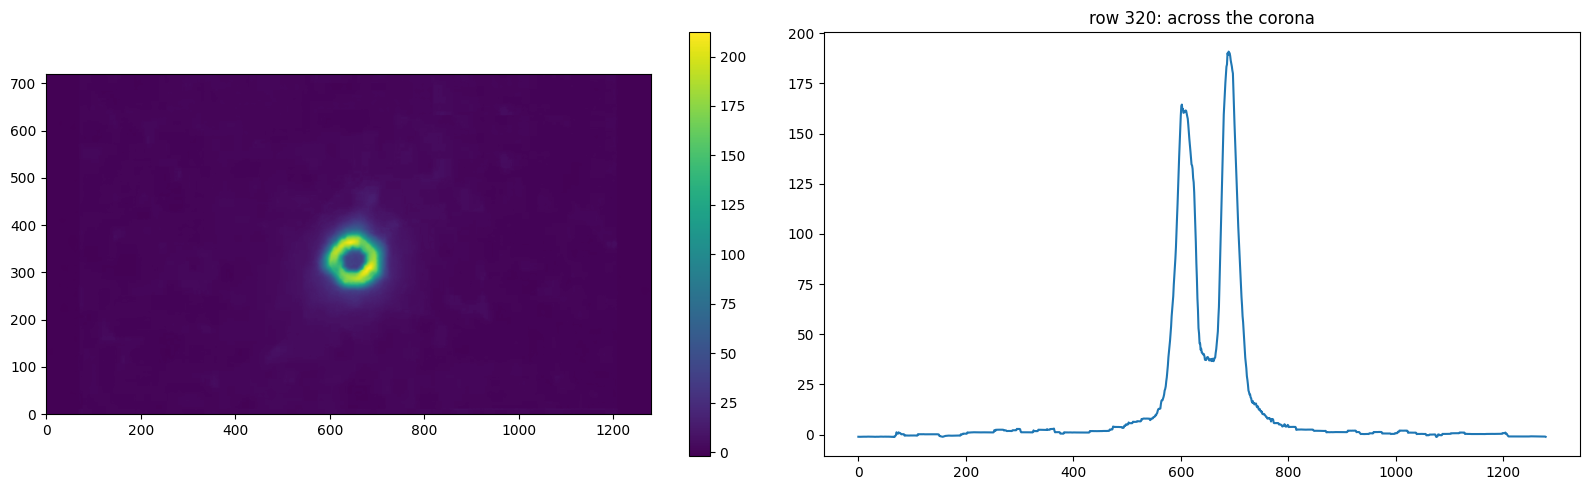

In [6]:
hdu2 = fits.open(pathd + listd[st + 6000])
img2 = hdu2[0].data

imgcut = img2[xp:xp+width,yp:yp+height]

plt.figure(figsize = [16,5])
plt.subplot(121)
plt.imshow(img2, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.plot(img2[320,:])
plt.title('row 320: across the corona')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Coronal Height')

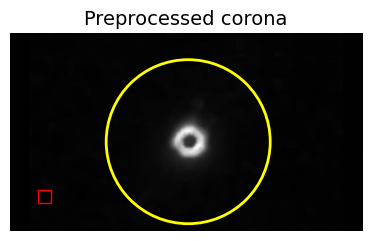

In [7]:
from matplotlib.patches import Rectangle, Circle

plt.figure(figsize = [10,6],num = 'img, rimg, pimg', dpi=100)
plt.subplot(221)
ax = plt.gca()
ax.imshow(img2, cmap='gray', origin = 'lower')
# 定义框的左下角坐标和宽高
#xp, yp, width, height = 20, 20, 100, 100
m,n = img2.shape
xp, yp, width, height = 100, 100, 50, 50
# 创建矩形并添加到坐标轴
rect = Rectangle((xp, yp), width, height, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)
# 定义圆心坐标和半径
center_x, center_y, radius = cc,cr, int(ridx/1.006*5 * 2)
# 创建圆并添加到坐标轴
circle = Circle((center_x, center_y), radius, linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(circle)
plt.axis('off')
plt.title('Preprocessed corona', fontsize=14)
plt.xlabel('Position Angle  / $\circ$', fontsize=14)
plt.ylabel('Coronal Height', fontsize=14)

In [8]:
fov = np.zeros([fn])
for i in range(fn):
    hdu = fits.open(pathd + listd[st + i])
    print('frame', i, 'loaded.')  
    img = hdu[0].data
    fov[i] = np.mean(img)
    
np.save('./output/fov.npy',fov)

In [9]:
bkgv = np.load('./output/fov.npy')
fov = bkgv.copy()

In [10]:
!pwd

/Users/liangyu/Library/CloudStorage/OneDrive-USTC/codes/gitcode/github/eclipse2023


In [11]:
sno, eno = 480, 12960
ts = (eno - sno) / 240
fov.shape,ts

((13282,), 52.0)

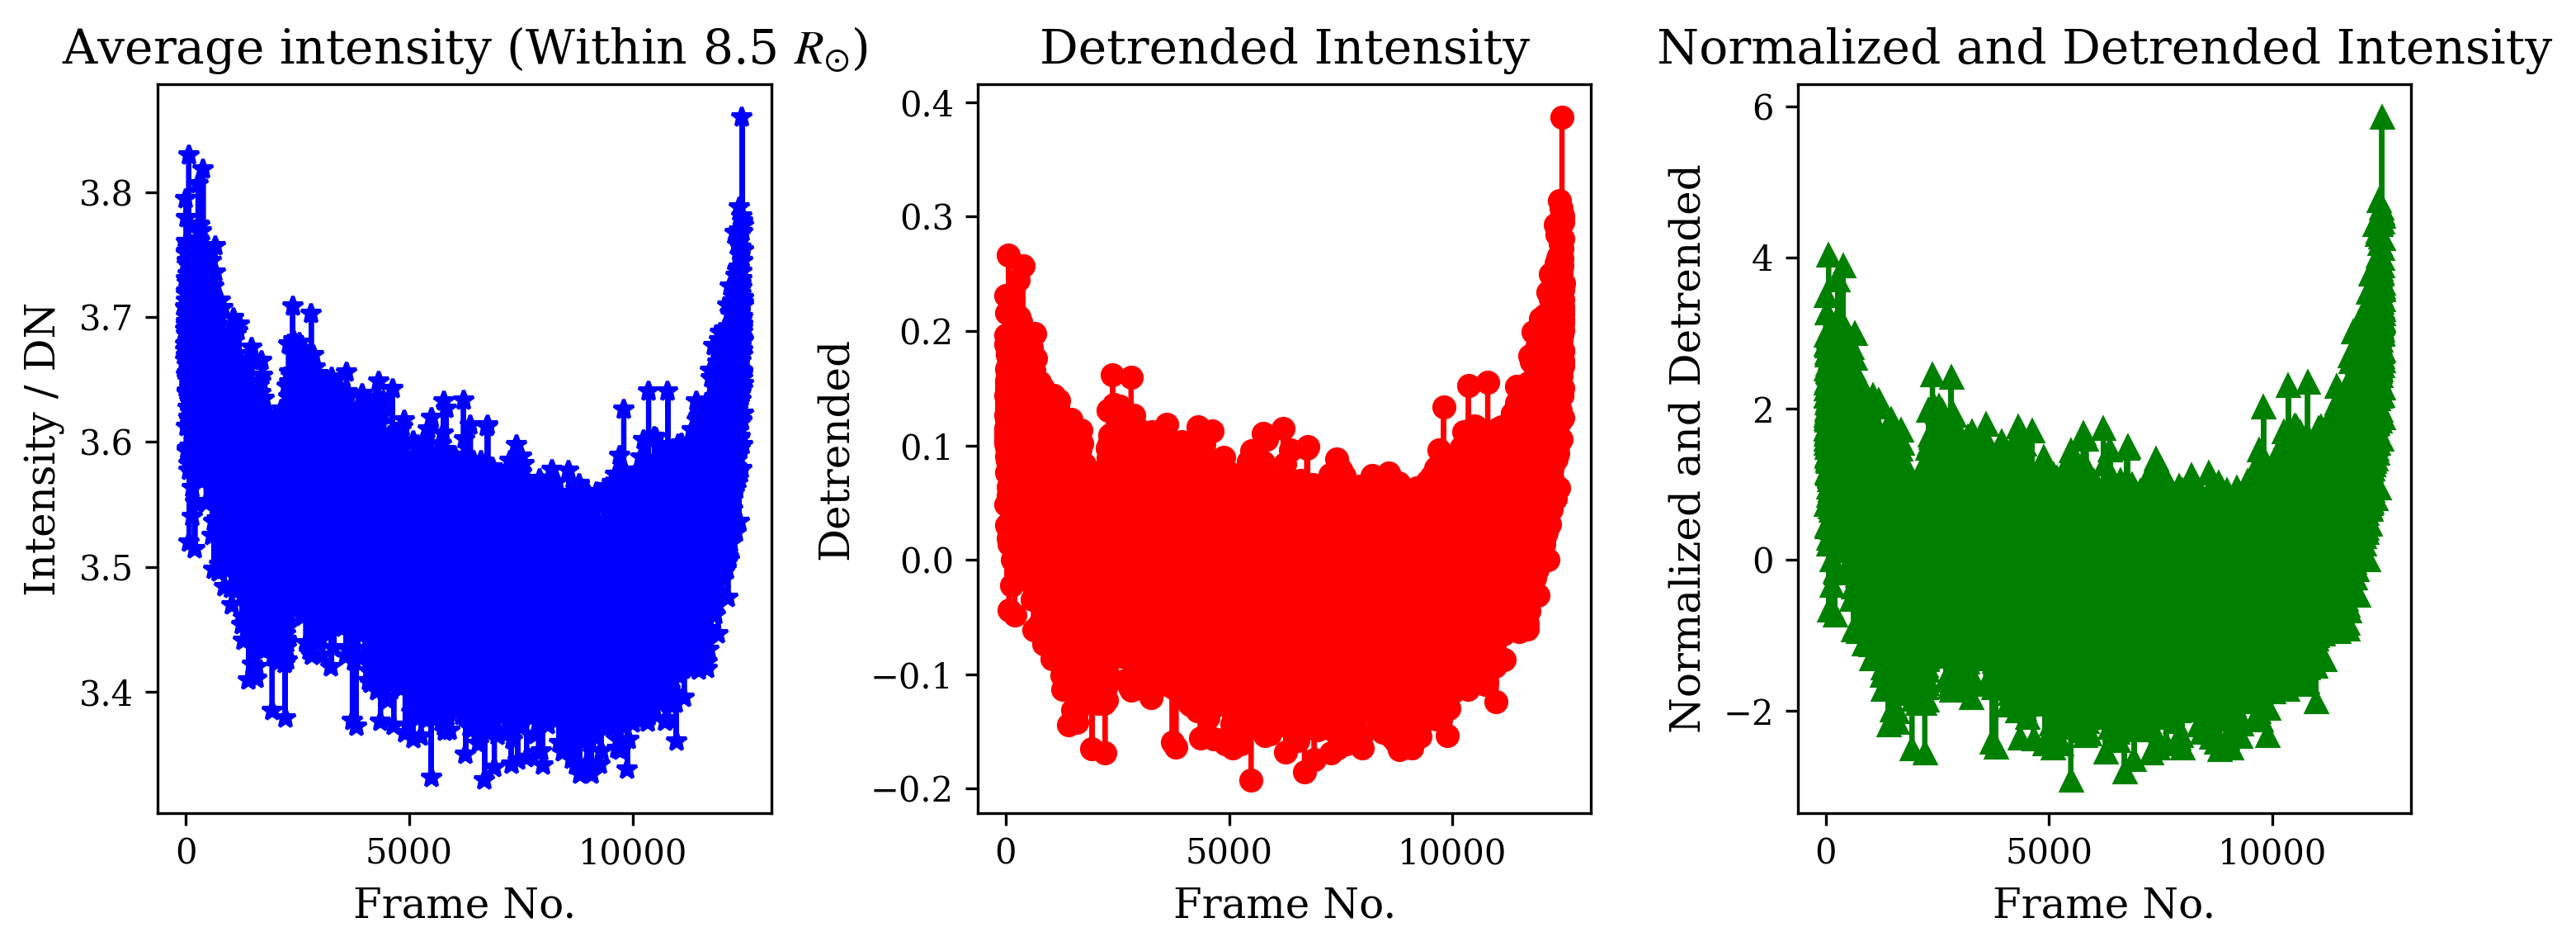

In [12]:

from __future__ import division
import numpy
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

ctf = eno - sno# 12000 # ctf: cut frame
dt = (ts)/(ctf-1) # In seconds
dat = fov[sno:eno]
#dat = dat / np.abs(np.max(dat))

title = 'Intensity of Ridx_Rlim1'
label = 'Ridx_Rlim1'
units = 'counts'
t0 = 0

# We also create a time array in years.
N = dat.size
t = np.arange(0, N) * dt + t0

#mother = wavelet.DOG(6)
mother = wavelet.Morlet()
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
#J = 7 / dj  # Seven powers of two with dj sub-octaves
J = (np.log2(N * dt / s0)) / dj
#alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
#alpha, _, _ = 0,0,0
alpha = 0

# We write the following code to detrend and normalize the input data by its
# standard deviation. Sometimes detrending is not necessary and simply
# removing the mean value is good enough. However, if your dataset has a well
# defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# above mentioned website, it is strongly advised to perform detrending.
# Here, we fit a one-degree polynomial function and then subtract it from the
# original data.
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
std = dat_notrend.std()         # Standard deviation
var = std ** 2                  # Variance
dat_norm = dat_notrend / std    # Normalized dataset

plt.rcParams.update({
    'font.size': 12,          
    'axes.titlesize': 14,     
    'axes.labelsize': 12,     
    'xtick.labelsize': 10,    
    'ytick.labelsize': 10,     
    'legend.fontsize': 12,     
    'figure.titlesize': 16,    
    'font.family': 'serif',   
    'mathtext.fontset': 'stix',
})


# intensity normaolized during the sample time series.
plt.figure(figsize=[10,4], dpi = 300)
plt.subplot(131)
plt.plot(dat, 'b-*')
plt.title('Average intensity (Within ' + '8.5 $R_{\odot}$)')
plt.xlabel('Frame No.')
plt.ylabel('Intensity / DN')

plt.subplot(132)
plt.plot(dat_notrend, 'r-o')
plt.title('Detrended Intensity')
plt.xlabel('Frame No.')
plt.ylabel('Detrended')

plt.subplot(133)
plt.plot(dat_norm, 'g-^')
plt.title('Normalized and Detrended Intensity')
plt.xlabel('Frame No.')
plt.ylabel('Normalized and Detrended')
plt.tight_layout()
pathfigs = './output/'
plt.savefig(pathfigs + 'intensity_fov.png', bbox_inches='tight')
plt.show()

/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_72214/2629984569.py:60: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


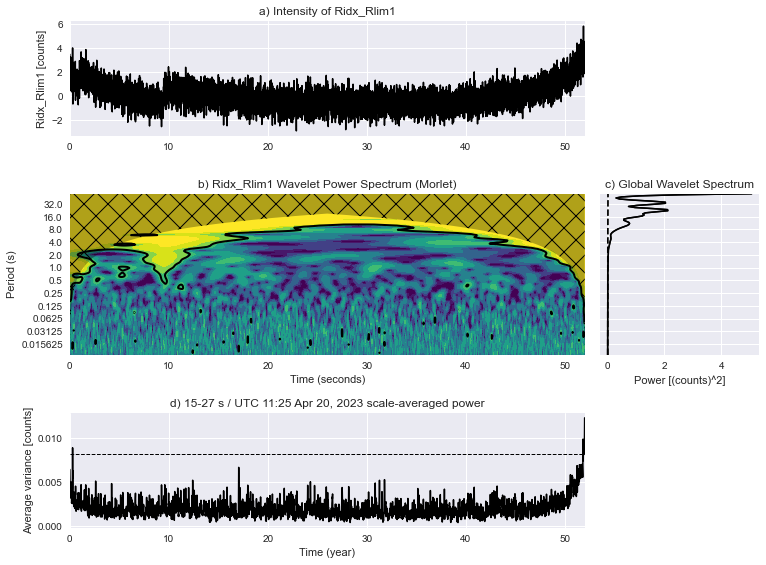

In [13]:
# https://qastack.cn/stats/134104/why-do-we-divide-by-the-standard-deviation-and-not-some-other-standardizing-fact
# wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
#                                                       mother)
# iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std   

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std   

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= s0) & (period < 6))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()

import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')

figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
#ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))
#plt.ylim(140,148)

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_xlabel('Time (seconds)')
bx.set_ylabel('Period (s)')
#fig.colorbar(im, cax=cbar_ax, orientation="vertical")
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
# 绘制数据
cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '-.', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
#cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        #linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
# cx.set_xlim([0, glbl_power.max() *0.0005])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}-{} s / UTC 11:25 Apr 20, 2023 scale-averaged power'.format(15 , 27))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
#plt.ylim(0,0.1)
ax.set_xlim([t.min(), t.max()])
pyplot.show()

/var/folders/j1/t8_gk27x5wq61xjjlpw5qqcw0000gn/T/ipykernel_72214/4188380482.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


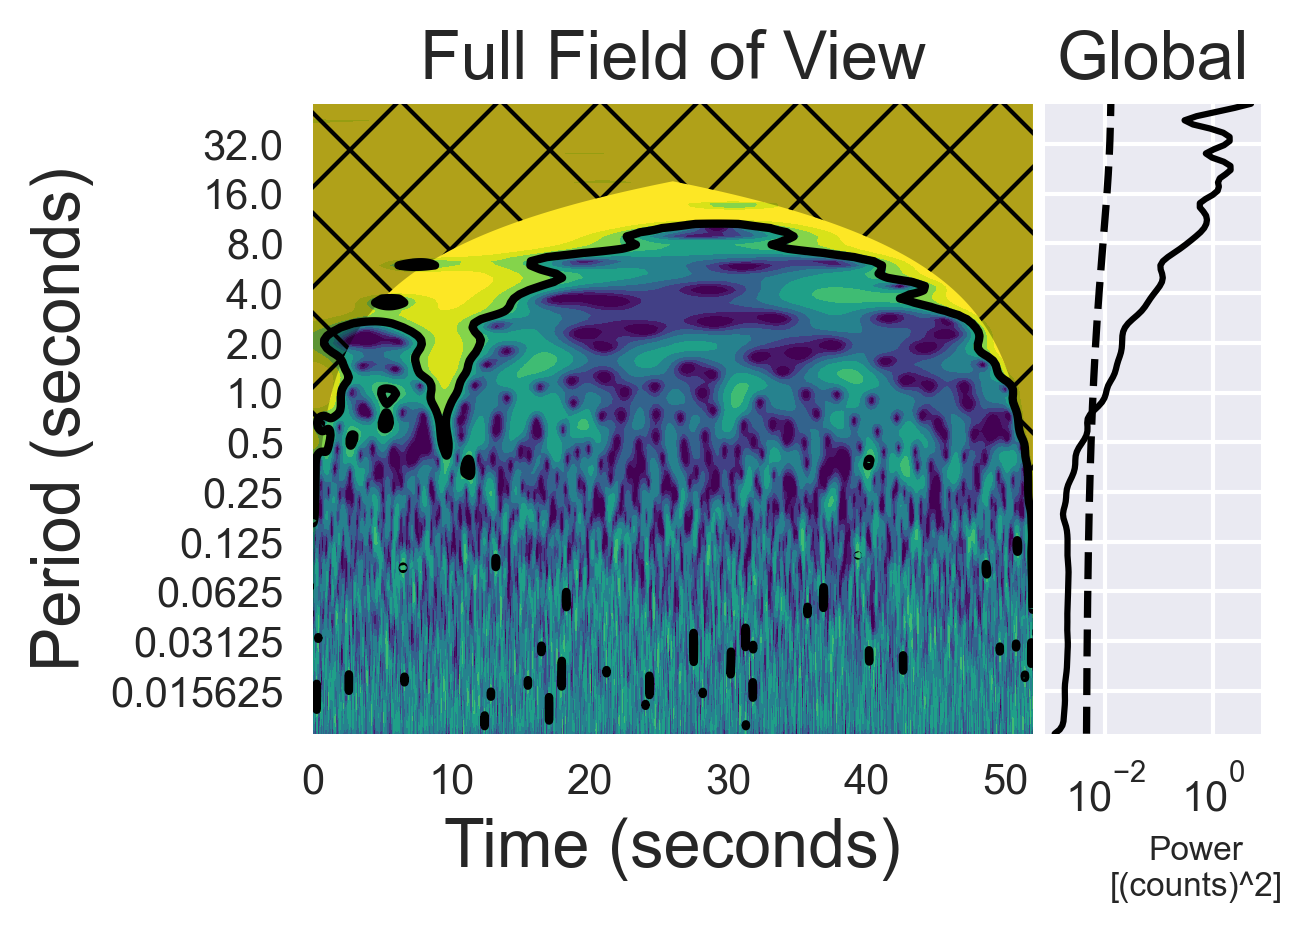

In [14]:
units = 'counts'
figprops = dict(figsize=(4,3))
fig = pyplot.figure(**figprops, dpi=300)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
# ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
# #ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat_norm, 'k', linewidth=1.5)
# ax.set_title('a) {}'.format(title))
# ax.set_ylabel(r'{} [{}]'.format(label, units))
# #plt.ylim(140,148)

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influence hatched area. Note that period
# scale is logarithmic.
#plt.axes((left, bottom, width, height), facecolor='grey')
bx = pyplot.axes([0.1, 0.18, 0.6, 0.7], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('Full Field of View', fontsize='16')
bx.set_xlabel('Time (seconds)', fontsize='16')
bx.set_ylabel('Period (seconds)', fontsize='16')
#fig.colorbar(im, cax=cbar_ax, orientation="vertical")
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Additional code

# Create Axes object cx and set shared y-axis
cx = plt.axes([0.71, 0.18, 0.18, 0.7], sharey=bx)

# Plot data
cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '-.', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)

# Set x-axis to logarithmic scale
cx.set_xscale('log')

# Set other properties
cx.set_title('Global', fontsize='16')
cx.set_xlabel('Power\n' + r'[({})^2]'.format(units), x=0.7, y=0.02, fontsize='8')
#cx.set_xlim([0, glbl_power.max()])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)
plt.tight_layout()

pathfigs = './output/'
plt.savefig(pathfigs + 'fovwv.png', bbox_inches='tight')
pyplot.show()
pyplot.close()


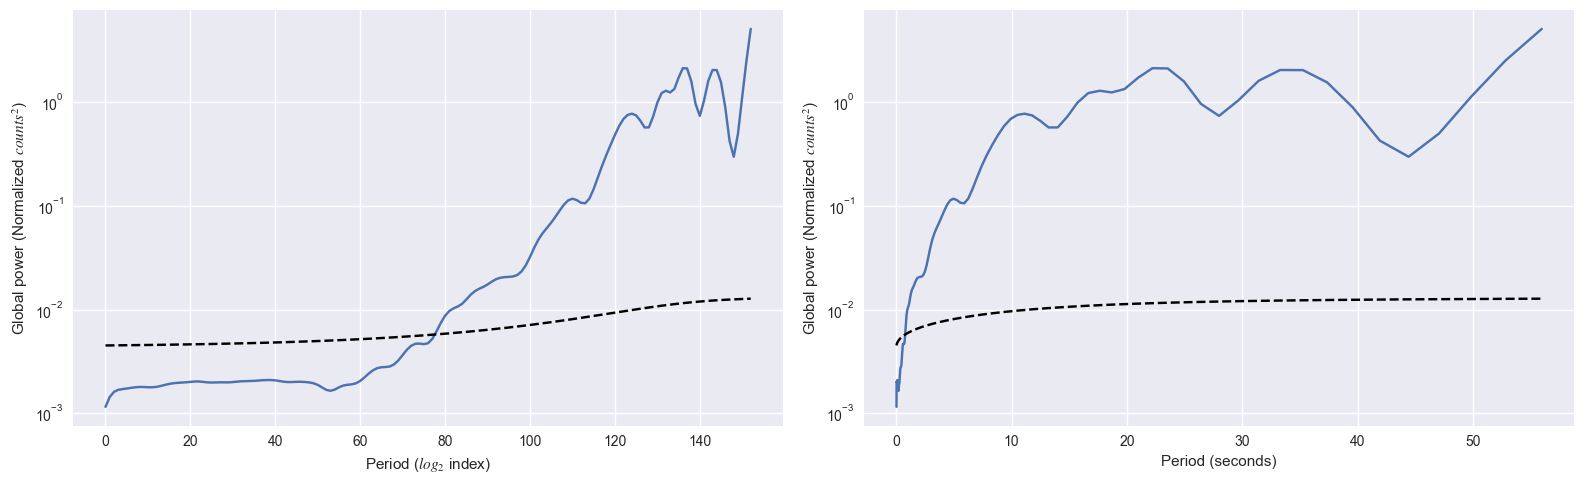

(153,) (153,) (153,)


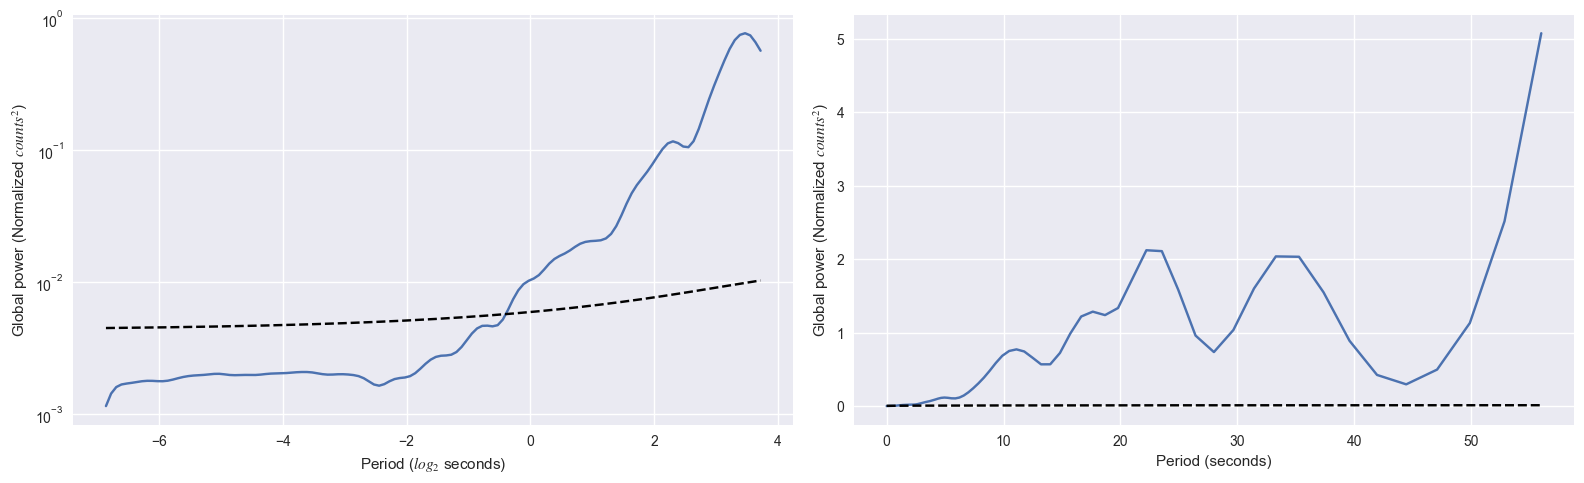

peak :  6.233862013434395 11.107479353664903 19.791278235900702 22.214958707329806
peakvalue :  0.11739300641482964 0.7723168194121418 1.3349548163657676 2.120496840532462
[6.233862013434395, 11.107479353664903, 19.791278235900702, 22.214958707329806] [0.11739300641482964, 0.7723168194121418, 1.3349548163657676, 2.120496840532462]


In [15]:
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(var * glbl_power)
plt.plot(glbl_signif, 'k--')
plt.xlabel('Period ($log_{2}$ index)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.yscale('log')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()

print(glbl_power.shape, glbl_signif.shape, period.shape)

plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(np.log2(period[0:128]) ,var * glbl_power[0:128])
plt.plot(np.log2(period[0:128]), glbl_signif[0:128], 'k--')
plt.xlabel('Period ($log_{2}$ seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.yscale('log')
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.xlabel('Period (seconds)')
plt.ylabel('Global power (Normalized $counts^{2}$)')
plt.tight_layout()
plt.show()

scl = 1

a1,a2 = np.argmax(glbl_power[100:115]), np.argmax(glbl_power[115:125])
a1 += 100
a2 += 115
a1 = a1 * scl
a2 = a2 * scl
#     print(a0,a1,a2)
#     print(period[int(a1)],period[int(a2)])
a0 = np.argmax(glbl_power[125:135])
a0 += 125
a0 = a0 * scl
a0

#     print(period[int(a1)],period[int(a2)])
a4 = np.argmax(glbl_power[135:140])
a4 += 135
a4 = a4 * scl
a4

print('peak : ',period[int(a1)],period[int(a2)],period[int(a0)],period[int(a4)])
print('peakvalue : ',var * glbl_power[int(a1)],var * glbl_power[int(a2)],var * glbl_power[int(a0)],var * glbl_power[int(a4)])

peaks11 = [period[int(a1)],period[int(a2)],period[int(a0)],period[int(a4)]]
values11 = [var * glbl_power[int(a1)],var * glbl_power[int(a2)],var * glbl_power[int(a0)],var * glbl_power[int(a4)]]
print(peaks11, values11)
# np.save('./output/peaks' + hnm + '.npy', peaks11)
# np.save( './output/values' + hnm + '.npy', values11)
# print('./output/peaks' + hnm + '.npy' + './output/values' + hnm + '.npy' + 'saved!')

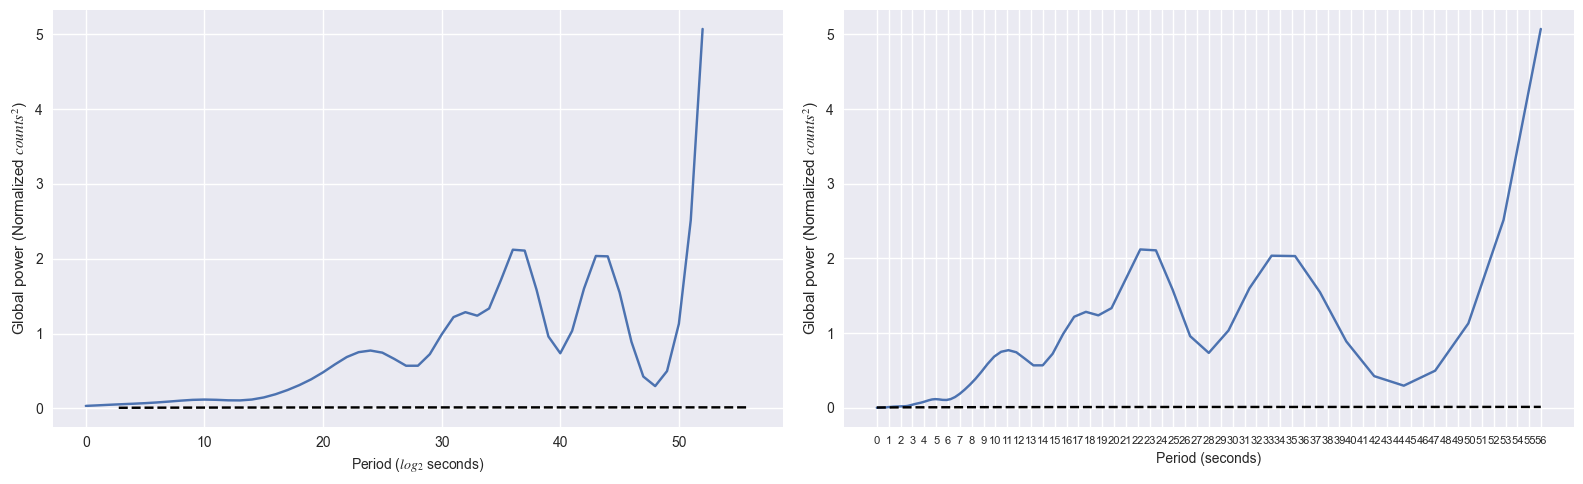

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the existing variables: var, glbl_power, period, glbl_signif

plt.figure(figsize=[16,5])

# Subplot 1
plt.subplot(121)
plt.plot(var * glbl_power[100::])
plt.plot(period[100::], glbl_signif[100::], 'k--')
plt.xlabel('Period ($log_{2}$ seconds)', fontsize=10)  # Set xlabel font size
plt.ylabel('Global power (Normalized $counts^{2}$)')

# # Set x-axis ticks at each unit, and rotate labels by 45 degrees
# plt.xticks(np.arange(min(period[100::]), max(period[100::])+1, 1), rotation=0, fontsize=8)  # Rotate 45 degrees and reduce font size

# Subplot 2
plt.subplot(122)
plt.plot(period, var * glbl_power)
plt.plot(period, glbl_signif, 'k--')
plt.xlabel('Period (seconds)', fontsize=10)  # Set xlabel font size
plt.ylabel('Global power (Normalized $counts^{2}$)')

# Set x-axis ticks at each unit, and rotate labels by 45 degrees
plt.xticks(np.arange(min(period), max(period)+1, 1), rotation=0, fontsize=8)  # Rotate 45 degrees and reduce font size

plt.tight_layout()
plt.show()
